In [1]:
    import msprime
    import tskit
    from IPython.display import SVG
    import numpy as np
    # Doing this to make the notebook outputs deterministic.
    # DO NOT DO THIS IN YOUR CODE
    msprime.core.set_seed_rng_seed(42)

(sec_mutations)=

# Mutation simulations

{ref}`Ancestry simulations<sec_ancestry>` in msprime simulate a random
ancestral history of a set of sampled genomes. While the trees representing
this history are very useful (and often all we need, for many purposes),
they do not include any information about what the actual genome **sequences**
would look like for these samples. To produce genetic variation data
(as represented by a [VCF file](https://samtools.github.io/hts-specs/VCFv4.2.pdf),
for example), we need to simulate some extra information: we need
*mutations*. Msprime provides a powerful and efficient way of superimposing
neutral mutations from a range of sequence evolution
{ref}`models <sec_mutations_models>` using the {func}`.sim_mutations`
function.

For example, here we simulate the ancestry of two diploids (and therefore
four sample genomes) and store the resulting {class}`tskit.TreeSequence`
object in the ``ts`` variable. We then simulate some mutations on
that tree sequence, and show the resulting tree with mutations:

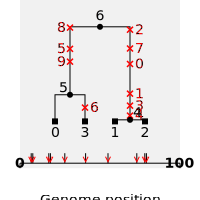

In [2]:
ts = msprime.sim_ancestry(2, sequence_length=100, random_seed=1234)
mts = msprime.sim_mutations(ts, rate=0.01, random_seed=5678)
SVG(mts.draw_svg())

We can see the variation data produced by these mutations most simply
via the {meth}`tskit.TreeSequence.variants` method:

In [3]:
for var in mts.variants():
    print(var.site.position, var.alleles, var.genotypes, sep="\t")

7.0	('T', 'G')	[0 1 1 0]
8.0	('A', 'T')	[0 1 1 0]
18.0	('T', 'A')	[0 1 1 0]
19.0	('A', 'C')	[0 1 1 0]
28.0	('C', 'G')	[0 1 1 0]
41.0	('T', 'C')	[1 0 0 1]
55.0	('T', 'G')	[0 0 0 1]
73.0	('A', 'C')	[0 1 1 0]
78.0	('C', 'G')	[1 0 0 1]
79.0	('G', 'T')	[1 0 0 1]


The [tskit](https://tskit.dev/tskit) library has many powerful
methods for working with mutation data --- see the
{ref}`tutorials:sec_tskit_getting_started` tutorial
for more information.

---

## Quick reference


{func}`.sim_mutations`
: Add simulated mutations to a tree sequence

**Models**

{class}`.JC69` (Nucleotides)
: Jukes & Cantor model ('69), equal probability of transitions between nucleotides

{class}`.HKY` (Nucleotides)
: Hasegawa, Kishino & Yano model ('85), different probabilities for transitions and transversions

{class}`.F84` (Nucleotides)
: Felsenstein model ('84), different probabilities for transitions and transversions

{class}`.GTR` (Nucleotides)
: Generalised Time-Reversible nucleotide mutation model

{class}`.BLOSUM62` (Amino acids)
: The BLOSUM62 model of time-reversible amino acid mutation

{class}`.PAM` (Amino acids)
: The PAM model of time-reversible amino acid mutation

{class}`.BinaryMutationModel` (Binary ancestral/derived)
: Binary mutation model with two flip-flopping alleles: "0" and "1".

{class}`.MatrixMutationModel` (General finite state model)
: Superclass of mutation models with a finite set of states

{class}`.InfiniteAlleles` (Integers)
: A generic infinite-alleles mutation model

{class}`.SLiMMutationModel` (Integers)
: An infinite-alleles model producing SLiM-style mutations

---

(sec_mutations_rate)=

## Specifying rates

The `rate` parameter of {func}`.sim_mutations` determines the rate of mutations per unit
of sequence length per generation. A rate must be specified for mutations to be generated.

In [4]:
ts = msprime.sim_ancestry(2, random_seed=1)
mts = msprime.sim_mutations(ts, rate=1, random_seed=1)
mts.num_mutations

7

Running {func}`.sim_mutations` on this simulated tree of length 1 with `rate=1`
produces 7 mutations.

Specifying higher rates lead to proportionately more mutations:

In [5]:
ts = msprime.sim_ancestry(2, random_seed=1)
mts = msprime.sim_mutations(ts, rate=5, random_seed=1)
mts.num_mutations

32

It's also possible to provide a {class}`.RateMap` which specifies variable
mutation rates over different stretches of the sequence.

In the following example, the mutation rate between positions 0 and 2 is 0.5,
between positions 2 and 5 is 0, and between positions 5 and 10 is 0.1:

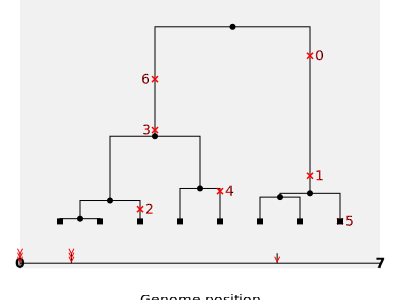

In [6]:
ts = msprime.sim_ancestry(4, sequence_length=7, random_seed=1)
ratemap = msprime.RateMap(position=[0, 2, 5, 7], rate=[0.5, 0, 0.1])
mts = msprime.sim_mutations(ts, rate=ratemap, random_seed=10)
SVG(mts.draw_svg(node_labels={}, size=(400, 300)))

As we can see from the output, there are three mutations at site 0 (position 0),
three mutations at site 1 (position 1), no mutations between positions 2 and 5
(where the mutation rate is zero) and one mutation at site 2 (position 5).
This illustrates that as the rate increases, the probability of recurrent mutation
(multiple mutations at a site) also increases.

:::{note}

If using a {class}`.RateMap` with {func}`.sim_mutations`, be sure that the final
position of the {class}`.RateMap` is the same as the
`sequence_length` of the tree sequence you're adding mutations to!

:::



(sec_mutations_discrete)=

## Discrete or continuous

As in {func}`.sim_ancestry` (see {ref}`sec_ancestry_discrete_genome`),
the `discrete_genome` parameter controls whether mutations should be placed at
discrete, integer coordinates or continuously at floating point positions.
`discrete_genome=True` is the default:

In [7]:
ts = msprime.sim_ancestry(4, sequence_length=5, random_seed=1)
mts = msprime.sim_mutations(ts, rate=0.1, random_seed=5)
mts.tables.sites.position

array([0., 1., 2., 4.])

Specifying `discrete_genome=False` places mutations at floating point positions
continuously along the genome.

In [8]:
mts = msprime.sim_mutations(ts, rate=0.1, random_seed=5, discrete_genome=False)
mts.tables.sites.position

array([0.44910517, 1.03359577, 1.37043233, 1.98368303, 2.07117512,
       2.20654612, 4.04140843])

:::{note}

Using `discrete_genome=False` means that the mutation model will conform
to the classic _infinite sites_ assumption, where each mutation in the simulation
occurs at a new site.

:::

(sec_mutations_time_span)=

## Restricting time span

The time range where mutations can be placed is specified using the `start_time`
and `end_time` parameters. For instance, the following only allows mutations to occur
earlier than time ``1`` in the tree:

In [9]:
ts = msprime.sim_ancestry(2, random_seed=1)
mts = msprime.sim_mutations(ts, rate=2, start_time=1, random_seed=1)
mts.tables.mutations.time

array([2.43665171, 2.36231214, 1.89044463, 1.75278168, 1.5317962 ,
       1.29553628, 1.18207318, 1.14345689])

Note, however, that the child node of the edge where the mutation occurred can be younger
than `start_time`.

In [10]:
mts.tables.nodes.time[mts.tables.mutations.node]

array([0.        , 1.9775205 , 0.        , 0.        , 0.        ,
       0.        , 0.17986861, 0.        ])

It is also possible to use multiple calls of {func}`.sim_mutations` with `start_time`
and `end_time` specified to simulate differing mutation rates at different
periods of time. For instance, the following code simulates mutations at a low rate
prior to time ``1`` and at a higher rate more recently.

In [11]:
ts = msprime.sim_ancestry(2, random_seed=1)
mts = msprime.sim_mutations(ts, rate=0.1, start_time=1, random_seed=1)
print(mts.tables.mutations.time)
mts = msprime.sim_mutations(mts, rate=4, end_time=1, random_seed=1)
print(mts.tables.mutations.time)

[1.29553628 1.15674901]
[1.29553628 1.15674901 0.96826157 0.90004028 0.80074457 0.72974006
 0.69232262 0.53881673 0.41919452 0.39676747 0.31342418 0.20233004
 0.19810148 0.05438014 0.02639678 0.01660881]


As explained in {ref}`the following section <sec_mutations_existing>`, reversing the order of these two
lines will result in an error, as older mutations must be added first.


(sec_mutations_silent)=

## Silent mutations

Some of these mutation models produce *silent mutations*,
that do not change the allelic state.
For instance, here are all the mutations in a small simulation
using the {class}`.HKY`:

In [12]:
def count_transitions(ts, alleles):
    counts = np.zeros((len(alleles), len(alleles)), dtype='int')
    for s in ts.sites():
        aa = s.ancestral_state
        for m in s.mutations:
            pa = aa
            da = m.derived_state
            if m.parent != tskit.NULL:
                pa = ts.mutation(m.parent).derived_state
            counts[alleles.index(pa), alleles.index(da)] += 1
    print("\t", "\t".join(alleles))
    for j, a in enumerate(alleles):
        print(f"{a}\t", "\t".join(map(str, counts[j])))

model = msprime.HKY(kappa=0.75, equilibrium_frequencies=[0.2, 0.3, 0.3, 0.2])
ts = msprime.sim_ancestry(
    5, random_seed=1, sequence_length=1e7, recombination_rate=1e-8,
    population_size=1000)
mts = msprime.sim_mutations(ts, rate=1e-8, model=model, random_seed=1)
count_transitions(mts, model.alleles)

	 A	C	G	T
A	 0	89	90	74
C	 102	36	148	63
G	 71	165	39	94
T	 60	62	89	0


There are a moderate but small number of C->C and G->G mutations.
This is because under the HKY model with these parameters,
the mutation rates for C and G is less than that of A and T.
However, msprime puts down mutations on the trees at *constant* rate;
and so to make the mutation process correct, some of these "mutations"
are chosen to be silent.
See {ref}`sec_mutations_matrix_mutation_theory` for more details on how this works.

Such silent mutations might be surprising, but they are harmless:
they do not affect summary statistics
(e.g., {meth}`tskit.TreeSequence.diversity`)
or genotypes in any way.
In fact, leaving them in makes msprime's mutation process *more* robust:
see {ref}`sec_mutations_state_independence` for details.

To demonstrate insensitivity to these silent mutations,
let's compute the number of segregating sites for the mutated tree sequence above.
Here's how many sites it has mutations at:

In [13]:
print(f"The tree sequence has {mts.num_sites} sites with mutations.")

The tree sequence has 1182 sites with mutations.


So, we might expect the total number of segregating sites to be 1182.
However, some are silent, and subtracting the number of these gets the same answer as
{meth}`tskit.TreeSequence.segregating_sites`:

In [14]:
num_silent = 0
for s in mts.sites():
    for m in s.mutations:
        pa = s.ancestral_state
        if m.parent != tskit.NULL:
            pa = mts.mutation(m.parent).derived_state
        if pa == m.derived_state:
            num_silent += 1

segsites = mts.segregating_sites(span_normalise=False)

print(f"The tree sequence has {num_silent} silent mutations,\n"
      f"and {segsites} segregating sites.")

The tree sequence has 75 silent mutations,
and 1107.0 segregating sites.


Indeed, 1182 - 75 = 1107.


(sec_mutations_existing)=

## Existing mutations

When you add mutations to a tree sequence which already contains them, the `keep` parameter
controls whether existing mutations are kept or discarded (the default is `keep=True`).
For instance, in final code block in {ref}`sec_mutations_time_span`, mutations were
progressively added to a simulated tree sequence, beginning with the oldest time period.
This could also be used to add mutations with different mutation models to different segments
of the genome.

While it is more natural to add younger mutations to a tree sequence which already contains
older mutations, you can also add mutations ancestral to existing mutations,
as in the following code block:

In [15]:
ts = msprime.sim_ancestry(5, random_seed=1)
mts = msprime.sim_mutations(ts, rate=1, random_seed=1)
mmts = msprime.sim_mutations(mts, rate=0.1, random_seed=5)
print(f"Before: {mts.num_mutations} mutations.\n"
      f"After: {mmts.num_mutations} mutations.")

Before: 4 mutations.
After: 6 mutations.


This might be done, for instance, if a tree sequence is the result of a forwards
simulation that has non-neutral variation, and you'd like to add neutral mutations.

(sec_mutations_state_independence)=

### Silent mutations and state-independence

Although it is possible to add new mutations ancestrally to
existing mutations, doing so can produce confusing situations.
For instance, new mutations added to an already mutated site
will not assign a new ancestral state: for instance, with the
{class}`.PAM` of amino acid mutation,
if a site has ancestral state ``V`` and a mutation with derived state ``I``,
and a new mutation is added ancestral to the existing one,
the derived state of the new mutation will be randomly assigned
(rather than being ``V`` as you might expect).
This can lead to unlikely or even impossible situations:
the new mutation in this example might be a ``G``,
since mutations from ``V`` to ``G`` and ``V`` to ``I`` are both reasonably likely.
However, a mutation from ``G`` to ``I`` is impossible under this model,
and we now have the chain V->G->I
(the chain is possible under the {class}`.BLOSUM62`, but unlikely).
In practice this is more confusing than concerning,
since it can only happen when the same site is mutated more than once,
which affects only a small proportion of sites.

The situation above occurred because the probability of mutating to ``I``
was very different depending on the initial state.
However, if derived alleles are chosen in a way *independent* of the previous state,
then adding mutations at rate {math}`\alpha`
and then adding mutations at rate {math}`\beta`
is *equivalent* to adding mutations once, at rate {math}`\alpha + \beta`.
A mutation model has this property if rows of its transition matrix are the same,
and is called *state independent* (or, *parent independent*).
For instance, mutations under the {class}`.JC69`
choose *any* derived allele with equal probability.
This means that the *result* of a mutation can be chosen without knowing
what the previous state at that site was ("state independence"),
which implies that adding new mutations above a given mutation does not affect
the probability of that mutation occurring.
However, this is only true if "any derived allele" includes the previous allele,
i.e., if we include {ref}`silent mutations <sec_mutations_silent>`.
The default Jukes-Cantor model will mutate an ``A`` to either a ``C``, ``G``, or ``T``
with equal probability, which we can check by looking at the *transition matrix*,
whose rows give the probability that each allele mutates into each other allele
(see {ref}`sec_mutations_matrix_mutations_models` for more):

In [16]:
jc69 = msprime.JC69()
jc69.transition_matrix

array([[0.        , 0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.        , 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.        , 0.33333333],
       [0.33333333, 0.33333333, 0.33333333, 0.        ]])

We can check that this does not produce any silent mutations:

In [17]:
rate = 1.5e-3
ts = msprime.sim_ancestry(5, random_seed=5, sequence_length=1e6)
mts = msprime.sim_mutations(ts, rate=rate, model=jc69, random_seed=7)
count_transitions(mts, jc69.alleles)

	 A	C	G	T
A	 0	1133	1137	1175
C	 1116	0	1090	1087
G	 1138	1121	0	1172
T	 1142	1133	1131	0


Although this model does not include silent mutations,
applying it more than once could produce some -
for instance, if one mutation with derived state ``C`` is inserted
above an existing mutation with the same derived state.
To make it state-independent, we have to choose the derived state
uniformly from *all* nucleotides:

In [18]:
pi_jc69 = msprime.JC69(state_independent=True)
pi_jc69.transition_matrix

array([[0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25]])

With this change, mutating twice with {class}`.JC69`
is *equivalent* to mutating once with rate equal to the sum of the rates.
In other words, these two operations are equivalent:

In [19]:
alpha = 0.4 * rate
beta = 0.6 * rate
# mutate once:
mts1 = msprime.sim_mutations(ts, rate=alpha + beta, model=pi_jc69, random_seed=7)
print("Mutated once:")
count_transitions(mts1, pi_jc69.alleles)
# or, mutate twice:
mts2 = msprime.sim_mutations(ts, rate=alpha, model=pi_jc69, random_seed=7)
mts2 = msprime.sim_mutations(mts2, rate=beta, model=pi_jc69, random_seed=8)
print("Mutated twice:")
count_transitions(mts2, pi_jc69.alleles)

Mutated once:


	 A	C	G	T
A	 832	863	890	860
C	 850	823	802	815
G	 865	833	860	877
T	 853	850	846	856
Mutated twice:
	 A	C	G	T
A	 849	838	845	847
C	 840	883	835	823
G	 827	885	840	835
T	 868	841	852	851


These are very similar - any differences are due to statistical noise.

However, now 25% of the mutations are silent.
These silent mutations are harmless, and will not affect most things at all.
However, they do count as mutations, and so including them decreases the
effective mutation rate.
Above, we produced ``mts`` by mutating with the default Jukes-Cantor model
at rate 1.5. Here, we produced ``mts1`` (and ``mts2``) using Jukes-Cantor
but with 25% of the mutations silent.
This means that to produce an set of mutations equivalent to ``mts``
that includes silent mutations, we need to use the parent-independent
Jukes-Cantor model with rate {math}`1/(1-0.25) = 4/3` times higher:

In [20]:
mts_with_silent = msprime.sim_mutations(ts, rate=rate * 4/3, model=pi_jc69, random_seed=12)
count_transitions(mts_with_silent, pi_jc69.alleles)

	 A	C	G	T
A	 1134	1124	1104	1226
C	 1070	1040	1185	1153
G	 1175	1106	1072	1118
T	 1086	1153	1117	1113


Note that the offdiagonal counts are similar to what we saw above for ``mts`` -
again, any differences are due to statistical noise.
Another way to see this is that nucleotide diversity is similar for ``mts`` and ``mts_with_silent``,
but is only 75% as big for ``mts1``:

In [21]:
print(f"Nucleotide diversity for default JC69 with rate {rate}: {mts.diversity():.4f}")
print(f"              parent-independent JC69 with rate {rate}: {mts1.diversity():.4f}")
print(f"              parent-independent JC69 with rate {rate * 4/3}: {mts_with_silent.diversity():.4f}")

Nucleotide diversity for default JC69 with rate 0.0015: 0.0053
              parent-independent JC69 with rate 0.0015: 0.0039
              parent-independent JC69 with rate 0.002: 0.0053


Here's the takeaways from this section:

```{attention}
1. If you're going to add mutations to the same tree sequence more than once,
    you should use the ``parent_independent`` mutation models
    (or carefully consider the consequences).
2. If you use a parent-independent model, you need to make your mutation rate higher,
    to account for the silent mutations. See {ref}`sec_mutations_adjusting_for_silent`
    for more details.
```


(sec_mutations_models)=

## Models

Mutation models are specified using the `model` parameter to
{func}`.sim_mutations`. This parameter can either take the form of a
string describing the model (e.g. `model="jc69"`) or an instance of a
model definition class (e.g `model=msprime.JC69()`).
Here are the available models; they are documented in more detail below.

- {class}`.BinaryMutationModel`: Basic binary mutation model with two flip-flopping alleles: "0" and "1".
- {class}`.JC69`: Jukes & Cantor model ('69), equal probability of transitions between nucleotides
- {class}`.HKY`: Hasegawa, Kishino & Yano model ('85), different probabilities for transitions and transversions
- {class}`.F84`: Felsenstein model ('84), different probabilities for transitions and transversions
- {class}`.GTR`: The Generalised Time-Reversible nucleotide mutation model, a general parameterization of a time-reversible mutation process
- {class}`.BLOSUM62`: The BLOSUM62 model of time-reversible amino acid mutation
- {class}`.PAM`: The PAM model of time-reversible amino acid mutation
- {class}`.MatrixMutationModel`: Superclass of the specific mutation models with a finite set of states
- {class}`.InfiniteAlleles`: A generic infinite-alleles mutation model
- {class}`.SLiMMutationModel`: An infinite-alleles model of mutation producing SLiM-style mutations

(sec_mutations_matrix_mutations_models)=

### Matrix Mutation Models

These classes are defined by an alphabet of possible alleles (`alleles`); an array of
probabilities that determines how likely each allele is to be the root, ancestral allele
(`root_distribution`); and a transition matrix specifying the probability for each allele
to mutate to every other allele. Each class has specific values of these parameters to
create the specific model. For your own custom model these parameters can be set using
{class}`msprime.MatrixMutationModel`. For more detail about how mutations are simulated
in these models see {ref}`sec_mutations_matrix_mutation_models_details`.

(sec_mutations_matrix_mutation_models_details)=

### Mutation Matrix Models Details

Mutation matrix models are specified by three things: an alphabet,
a root distribution, and a transition matrix.
These leave one free parameter: an overall mutation rate,
specified by the mutation `rate` in the call to {func}`.sim_mutations`.
Concisely,
the underlying model of mutation is a continuous-time Markov chain on the alphabet,
started by a draw from `root_distribution`, and
with instantaneous transition rate from `i` to `j` that is equal to
`rate` multiplied by `transition_matrix[i,j]`.
The `root distribution` and every row in the `transition_matrix`
must give *probabilities*, i.e., they must be nonnegative numbers summing to 1.
For the precise interpretation of these parameters
(especially when the transition matrix has nonzero entries on the diagonal)
see {ref}`sec_mutations_matrix_mutation_theory`.

You can define your own, but you probably don't need to:
there are several mutation matrix models already implemented in `msprime`,
using binary (0/1), nucleotide, or amino acid alphabets:

### Defining your own finite-sites model

If you want to define your own {class}`.MatrixMutationModel`, you have a good
deal of freedom. For instance, here's a "decomposition/growth/disturbance"
mutation model, where the only possible transitions are 🎄 to 🔥, 🔥 to 💩, and
💩 to 🎄, with the first transition happening at one-fifth the rate of the
other two:

In [22]:
alleles = ["💩", "🎄", "🔥"]
model = msprime.MatrixMutationModel(
    alleles,
    root_distribution = [1.0, 0.0, 0.0],
    transition_matrix = [[0.0, 1.0, 0.0],
                         [0.0, 0.8, 0.2],
                         [1.0, 0.0, 0.0]]
)
ts = msprime.sim_ancestry(6, population_size=10, random_seed=2, sequence_length=7)
mts = msprime.sim_mutations(ts, rate=2, random_seed=1, model=model)


We have simulated from this model at rate 2, so the overall rate of mutation
from 💩 to 🎄 and 🔥 to 💩 is 2, and from 🎄 to 🔥 is {math}`2 \times 0.2 = 0.4`.
As a result, roughly 5/7th of the states will be 🎄, with the remainder
divided evenly between 💩 and 🔥. Here is the resulting "genotype matrix":

In [23]:
for v in mts.variants():
   print("".join(v.alleles[k] for k in v.genotypes))



🔥🎄🎄🎄💩🎄🎄🎄🎄🎄🎄🎄
💩💩💩🎄🎄🎄🎄💩🎄🎄🎄🎄
🎄🎄🔥🔥💩🎄🎄🎄🎄🎄🎄🎄
🎄🎄💩🔥🎄🎄🎄🎄💩💩🔥💩
💩🎄🎄🎄🔥🎄🎄🎄🎄🎄🔥🎄
🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄
💩🎄🎄🎄🎄💩🎄🎄🎄💩🎄💩


(sec_mutations_matrix_mutation_theory)=

### Parameterization of Matrix Mutation Models

Mutation matrix models are specified by three things: an alphabet,
a root distribution, and a transition matrix.
These leave one free parameter: an overall mutation rate,
specified by the mutation `rate` in the call to {func}`.sim_mutations`.
Concisely,
the underlying model of mutation is a continuous-time Markov chain on the alphabet,
started by a draw from `root_distribution`, and
with instantaneous transition rate from `i` to `j` that is equal to
`rate` multiplied by `transition_matrix[i,j]`.
The `root distribution` and every row in the `transition_matrix`
must give *probabilities*, i.e., they must be nonnegative numbers summing to 1.

To interpret these parameters,
it helps to know how the underlying mutational process is implemented.
First, mutations are placed on the tree,
with a mean density equal to the `rate`, per unit of time and sequence length.
If `discrete_genome=False` then this is an infinite-sites model,
so each mutation occurs at a distinct position along the genome.
If `discrete_genome=True` (the default setting) then at each integer position,
each branch of the tree at that position gets a Poisson number of mutations
with mean equal to `rate` multiplied by the length of the branch.
Next, each site that has a mutation is assigned an ancestral state,
i.e., the allele at the root of the tree at that position,
by drawing an allele from the probabilities in the `root_distribution`.
Now, each mutation is examined, moving down the tree,
and a derived state is chosen using the probabilities given in the
row of the `transition_matrix` that corresponds to the "parental state",
i.e., the allele that this mutation will replace.
Importantly, the mutation is recorded even if the chosen allele is the same
as the parental allele - so, if the diagonal of the transition matrix
contains nonzero entries, then the mutated tree sequence will
(probably) contain silent mutations.

Some facts about Markov chains are useful to interpret the statistics
of these mutation models.
First, suppose we have tabulated all mutations, and so for each pair of alleles
{math}`i` and {math}`j` we have the proportion of mutations that caused an {math}`i \to j` change.
If allele {math}`i` mutates to a different allele, the chance it mutates to allele {math}`j`
is proportional to `transition_matrix[i,j]` but excluding the diagonal (no-change) entry,
so is equal to `transition_matrix[i,j] / (1 - transition_matrix[i,i])`.
Second, suppose that an ancestor carries allele {math}`i` at a given position.
The probability that her descendant some time {math}`t` in the future carries allele {math}`j` at that position
is given by a matrix exponential of
the scaled [infinitestimal rate matrix](<https://en.wikipedia.org/wiki/Transition_rate_matrix>) of the Markov chain,
which can be computed as follows:

```{code-block} python
import scipy

Q = (transition_matrix - np.eye(len(alleles)))
Pt = scipy.linalg.expm(t * rate * Q)[i,j]

```

If the top of a branch of length {math}`t` has allele {math}`i`,
the bottom of the branch has allele {math}`j` with probability `Pt[i,j]`.


(sec_mutations_adjusting_for_silent)=

#### Adjusting mutation rates for silent mutations

As discussed in {ref}`sec_mutations_silent`, matrix mutation models can insert *silent* mutations,
which may make it difficult to set the mutation rate appropriately,
since by "mutation rate" we mean the rate of appearance of mutations that *change* the allelic state.
However, the "mutation rate" is not in fact a single value: it depends on context,
as some alleles may tend to mutate more than others.

As an example of how to appropriately adjust the mutation rate to produce a given expected diversity,
take the following somewhat contrived problem.
Suppose we generate a tree sequence of 1000 samples of 10Mb from a population of size 1,000,
which has mutations generated under the HKY model with {math}`\kappa = 0.75`
and equilibrium frequencies {math}`\pi = [0.1, 0.2, 0.3, 0.4]`.
We'd like to choose the mutation rate {math}`\mu` so that the mean genetic diversity
is equal to 0.001.
If this was equal to the usual {math}`\theta = 4Nu`, we'd need a "mutation rate"
of {math}`u = 2.5 \times 10^{-7}`, so we know we'll need a number slightly higher than that.

To do this, let's figure out the mean rate of appearance of silent mutations.
We know that (a) the rate of appearance of silent mutations per nucleotide is given by {math}`\mu`
times the diagonal of the transition matrix, and (b) the equilibrium frequency of the four
nucleotides is given by {math}`\pi`. Multiplying these together and adding them up
gives us the expected proportion of mutations that are silent.
Now, writing that we want {math}`u` to equal {math}`\mu` times one minus the this proportion,
we get {math}`2.5 \times 10^{-7} = \mu (1 - \sum_i \pi_i P_{ii})`, so
solving for {math}`\mu` gives us:

In [24]:
pi = np.array([0.1, 0.2, 0.3, 0.4])
hky = msprime.HKY(kappa=0.75, equilibrium_frequencies=pi)
P = hky.transition_matrix
u = 2.5e-7
mu = u / (1 - np.sum(pi * np.diag(P)))
print(f"Mutation rate should be increased by a factor of {mu/u:.2f}.")

Mutation rate should be increased by a factor of 1.28.


Now, let's verify we get the nucleotide diversity we were aiming for:

In [25]:
ts = msprime.sim_ancestry(1000, population_size=1000, sequence_length=1e7, recombination_rate=1e-8, random_seed=5)
mts = msprime.sim_mutations(ts, rate=mu, model=hky, random_seed=27)
theta = mts.diversity()
print(f"Genetic diversity: {theta}.")

Genetic diversity: 0.0010836445272138172.


That's pretty close to 0.001! The difference is within statistical error.


(sec_mutations_mutation_infinite_alleles)=

### Infinite Alleles Mutation Models

You can also use a model of *infinite alleles* mutation: where each new mutation produces a unique,
never-before-seen allele. The underlying mutation model just assigns the derived state
to be a new integer every time a new mutation appears.
By default these integers start at zero, but a different starting point can be chosen,
with the `start_allele` parameter.
It does this globally across all mutations, so that the first assigned allele will be `start_allele`,
and if `n` alleles are assigned in total (across ancestral and derived states),
these will be the next `n-1` integers.
Many theoretical results are derived based on this mutation model (e.g., Ewens' sampling formula).

For instance, here we'll simulate with the infinite alleles model on a single tree,
and print the resulting tree, labeling each mutation with its derived state:

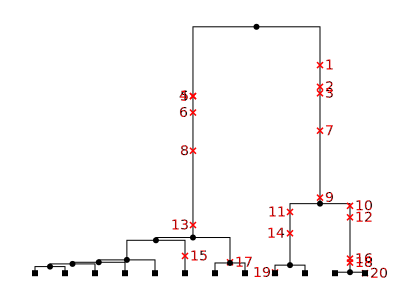

In [26]:
ts = msprime.sim_ancestry(6, random_seed=2, sequence_length=1)
model = msprime.InfiniteAlleles()
mts = msprime.sim_mutations(ts, rate=2, random_seed=1, model=model)
t = mts.first()
ml = {m.id: m.derived_state for m in mts.mutations()}
SVG(t.draw_svg(mutation_labels=ml, node_labels={}, size=(400, 300)))


Apparently, there were 20 mutations at this site, but the alleles present in the population are
"13" (in five copies), "17" (in two copies), and one copy each of "14", "15", "19", and "20".
Note that all other mutations on the tree are not observed in the population as they have
been are "overwritten" by subsequent mutations.


:::{warning}

Neither this nor the next infinite alleles mutation model check to see if the alleles
they produce already exist at the mutated sites. So, if you are using these
models to add mutations to an already-mutated tree sequence, it is up to you
to set the starting allele appropriately, and to make sure the results make sense!

:::

(sec_mutations_mutation_slim_mutations)=

### SLiM mutations

A special class of infinite alleles model is provided for use with [SLiM](<https://messerlab.org/slim/>),
to agree with the underlying mutation model in SLiM.
As with the InfiniteAlleles model, it assigns each new mutation a unique integer,
by keeping track of the `next_id` and incrementing it each time a new mutation appears.

This differs from the {class}`.InfiniteAlleles` because mutations
in SLiM can "stack": new mutations can add to the existing state, rather than
replacing the previous state. So, derived states are comma-separated lists of
mutation IDs, and the ancestral state is always the empty string. For instance,
if a new mutation with ID 5 occurs at a site, and then later another mutation
appears with ID 64, the sequence of alleles moving along this line of descent
would be `""`, then `"5"`, and finally `"5,64"`. Furthermore, the mutation
model adds SLiM metadata to each mutation, which records, among other things,
the SLiM mutation type of each mutation, and the selection coefficient (which
is always 0.0, since adding mutations in this way only makes sense if they are
neutral). For this reason, the model has one required parameter: the `type`
of the mutation, a nonnegative integer. If, for instance, you specify
`type=1`, then the mutations in SLiM will be of type `m1`. For more
information, and for how to modify the metadata (e.g., changing the selection
coefficients), see
[the pyslim documentation](<https://pyslim.readthedocs.io/en/latest/>).
For instance,

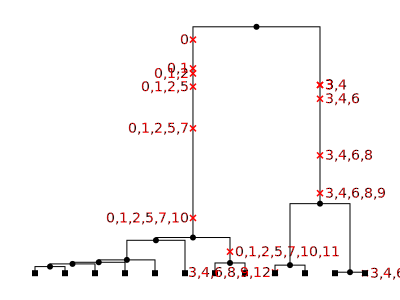

In [27]:
model = msprime.SLiMMutationModel(type=1)
mts = msprime.sim_mutations(
    ts, rate=1, random_seed=1, model=model)
t = mts.first()
ml = {m.id: m.derived_state for m in mts.mutations()}
SVG(t.draw_svg(mutation_labels=ml, node_labels={}, size=(400, 300)))


These resulting alleles show how derived states are built.

The behavior of this mutation model when used to add mutations to a previously mutated
tree sequence can be subtle. Let's look at a simple example.
Here, we first lay down mutations of type 1, starting from ID 0:

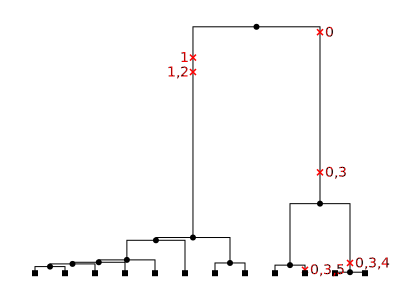

In [28]:
model_1 = msprime.SLiMMutationModel(type=1)
mts_1 = msprime.sim_mutations(ts, rate=0.5, random_seed=2, model=model_1)
t = mts_1.first()
ml = {m.id: m.derived_state for m in mts_1.mutations()}
SVG(t.draw_svg(mutation_labels=ml, node_labels={}, size=(400, 300)))


Next, we lay down mutations of type 2.
These we assign starting from ID 100,
to make it easy to see which are which:
in general just need to make sure that we start at an ID greater than any
previously assigned.

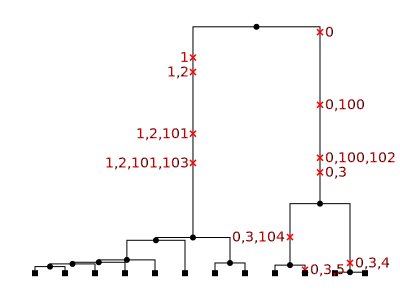

In [29]:
model_2 = msprime.SLiMMutationModel(type=2, next_id=100)
mts = msprime.sim_mutations(
    mts_1, rate=0.5, random_seed=3, model=model_2, keep=True)
t = mts.first()
ml = {m.id: m.derived_state for m in mts.mutations()}
SVG(t.draw_svg(mutation_labels=ml, node_labels={}, size=(400, 300)))


Note what has happened here: on the top branch on the right side of the tree,
with the first model we added two mutations: first a mutation with ID `0`,
then a mutation with ID `3`.
Then, with the second model, we added two more mutations to this same branch,
with IDs `100` and `102`, between these two mutations.
These were added to mutation `0`, obtaining alleles `0,100` and `0,100,102`.
But then, moving down the branch, we come upon the mutation with ID `3`.
This was already present in the tree sequence, so its derived state is not modified:
`0,3`. We can rationalize this, post-hoc, by saying that the type 1 mutation `3`
has "erased" the type 2 mutations `100` and `102`.
If you want a different arrangement,
you can go back and edit the derived states (and metadata) as you like.